In [1]:
import pandas.io.sql as psql
import json
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit import rdBase
from rdkit import DataStructs
#import psycopg2 as pg


import pandas as pd
import sqlalchemy as db
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from pandas import concat

from collections import OrderedDict
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split

import cheminformatics.utils.multicore as multicore
import time
import math
from multiprocessing import Pool,Queue, Process, cpu_count
import os
import sys

import chemfp
from chemfp import search

import numpy as np

import random
from numpy import median 
from itertools import combinations

from rdkit.Chem import QED 

# read core info

In [2]:
pool = pd.read_csv("../03_target_pred/Results/query_with_targets.csv",encoding='utf-8')

In [3]:
print(pool.shape)
pool.head()

(1448145, 3)


query_index                   query_smiles                  targets
0         9812   C1CCCC(N2CCN(C3CCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
1        13121   C1CCC(N2CCN(C3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
2         9438  C1CCCC(N2CCC(N3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
3        12848   C1CCC(N2CCC(N3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
4        12853  C1CCC(N2CCC(N3CCCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}

In [4]:
targets_novelty_scores = pd.read_csv("../01_chembl_data_prep/Results/targets_with_novelty_scores.csv",encoding='utf-8')

In [5]:
targets_novelty_scores.head()

target_chembl_id   clan     pfam  clan_novelty_score  pfam_novelty_score  \
0    CHEMBL1075021   c519  PF00204            0.880137            0.813719   
1    CHEMBL1075022   c637  PF00204            0.166667            0.813719   
2    CHEMBL1075023  c1484  PF01048            0.000000            0.269437   
3    CHEMBL1075024   c582  PF03060            0.250000            0.250000   
4    CHEMBL1075025  c1864  PF01255            0.000000            0.000000   

   in_actives  in_predicted  
0           1             0  
1           1             0  
2           1             1  
3           1             1  
4           1             1

In [6]:
clusters = pd.read_csv("../02_zinc15_data_prep/Results/parsed_clusers_04.csv")
clusters['cluster_id'] = np.where((clusters.cluster_id == 'false_singleton'),clusters.member,clusters.member)
clusters.head()

/Home/ii/neannm/anaconda3/envs/rdkit3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cluster_id   member
0     1000192  1000192
1     1000844  1000844
2     1001115  1001115
3     1001430  1001430
4     1001929  1001929

# novel7_elitist_pfam_novelty_parallel_15k_500_300_0randoms 

## fitness score evolution

In [7]:
evolution_scores = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_15k_500_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_15k_500_300_0randoms.csv",encoding='utf-8')

In [8]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [9]:
print(evolution_scores.shape)
evolution_scores.head()

(150000, 3)


fitness  generation   use
0  0.353634           0  True
1  0.354191           0  True
2  0.355222           0  True
3  0.359861           0  True
4  0.353779           0  True

In [10]:
evolution_scores.tail()

fitness  generation    use
149995  0.406135         299  False
149996  0.398797         299  False
149997  0.399404         299  False
149998  0.398156         299  False
149999  0.400875         299  False

In [11]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.353634           0  True
1  0.354191           0  True
2  0.355222           0  True
3  0.359861           0  True
4  0.353779           0  True

Text(0, 0.5, 'fitness')

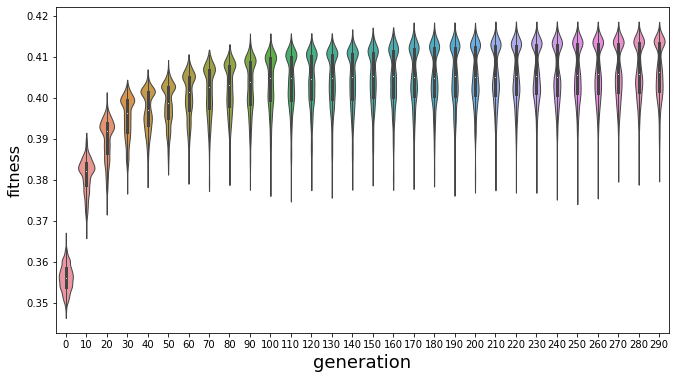

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [13]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  0.366400   True
1           1  0.368263  False
2           2  0.376282  False
3           3  0.377179  False
4           4  0.380260  False

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

<AxesSubplot:xlabel='generation', ylabel='fitness'>

Text(0, 0.5, 'fitness')

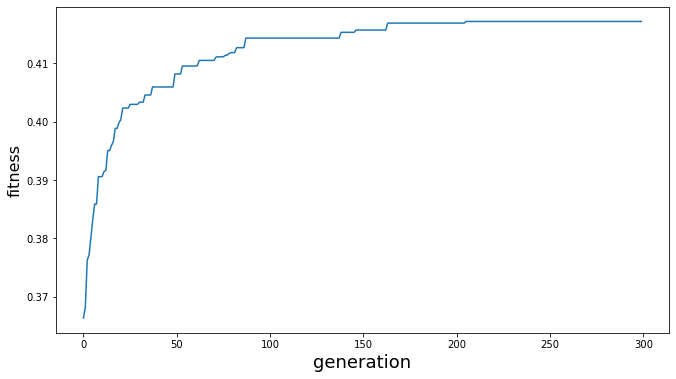

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

In [16]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.3664002647433282
max overall: 0.4171094376222335
improvement: 13.839829759519482


## population scaffold change

In [17]:
best_pop_at_0 = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_15k_500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_15k_500_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [18]:
best_pop_overall = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_15k_500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_15k_500_300_0randoms_205.csv",encoding='utf-8',names=['file_index'])

In [19]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

15000
15000


In [20]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                      query_smiles  \
0   1404188.0      2479834               O=C1Nc2ccc(Br)cc2/C1=N/n1c(O)csc1=S   
1    438668.0      2715026  O=C(COC(=O)c1ccc(Br)cc1)Nc1ccc2[nH]c(=O)[nH]c2c1   
2    263036.0       459480              C=c1ccsc1=Cc1sc(N2CCC[C@H](C)C2)nc1O   
3    663626.0      2733357  O=C(CS(=O)(=O)c1ccccc1)Nc1ccc(-c2nc3ccccc3o2)cc1   
4   1339951.0      1861157              COc1ccccc1-n1cc(Nc2ccccc2C(=O)O)cc1O   

                                             targets  
0                                    {CHEMBL3038499}  
1                                    {CHEMBL1293277}  
2                                    {CHEMBL1293303}  
3  {CHEMBL1293294,CHEMBL5567,CHEMBL1293277,CHEMBL...  
4                            {CHEMBL5847,CHEMBL4681}

In [21]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                      query_smiles  \
0   1133100.0      2416880                   NC(=O)CSc1nc2ccccc2n1Cc1ccccc1F   
1    442243.0       688039               CCc1cc(Br)ccc1NC(=O)COC(=O)c1ccccc1   
2    241387.0      2804607       O=C(NCc1cccc(C(F)(F)F)c1)c1ccc(N2CCOCC2)cc1   
3   1279453.0      2630448  O=C(C[C@H]1C[C@H]2CC[C@H]1C2)Nc1nc(-c2cccnc2)cs1   
4   1134916.0      2475869             O=C1COc2ccc(C(=O)c3ccccc3C(=O)O)cc2N1   

                                             targets  
0                                       {CHEMBL1784}  
1                                    {CHEMBL1741209}  
2                                       {CHEMBL4698}  
3  {CHEMBL1293294,CHEMBL1075138,CHEMBL1293231,CHE...  
4                      {CHEMBL1075138,CHEMBL1293258}

In [22]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [23]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [24]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 10870
max overall: 10910
% improvement: 0.36798528058877644
 improvement: 40


## cluster representation change

In [25]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                      query_smiles  \
0   1404188.0      2479834               O=C1Nc2ccc(Br)cc2/C1=N/n1c(O)csc1=S   
1    438668.0      2715026  O=C(COC(=O)c1ccc(Br)cc1)Nc1ccc2[nH]c(=O)[nH]c2c1   
2    263036.0       459480              C=c1ccsc1=Cc1sc(N2CCC[C@H](C)C2)nc1O   
3    663626.0      2733357  O=C(CS(=O)(=O)c1ccccc1)Nc1ccc(-c2nc3ccccc3o2)cc1   
4   1339951.0      1861157              COc1ccccc1-n1cc(Nc2ccccc2C(=O)O)cc1O   

                                             targets  \
0                                    {CHEMBL3038499}   
1                                    {CHEMBL1293277}   
2                                    {CHEMBL1293303}   
3  {CHEMBL1293294,CHEMBL5567,CHEMBL1293277,CHEMBL...   
4                            {CHEMBL5847,CHEMBL4681}   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                      murcko_smiles  cluster_id   member  
0                      O=C1Nc2ccccc2/C1=N/n1ccsc1=S     2479834  2479834  
1      O=C(COC(=O)c1ccccc1)Nc1ccc2[nH]c(=O)[nH]c2c1     2715026  2715026  
2                      C=c1ccsc1=Cc1cnc(N2CCCCC2)s1      459480   459480  
3  O=C(CS(=O)(=O)c1ccccc1)Nc1ccc(-c2nc3ccccc3o2)cc1     2733357  2733357  
4                     c1ccc(Nc2ccn(-c3ccccc3)c2)cc1     1861157  1861157
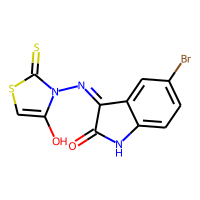
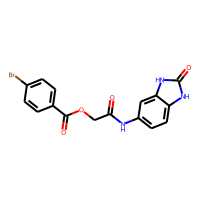
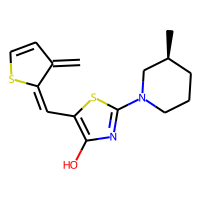
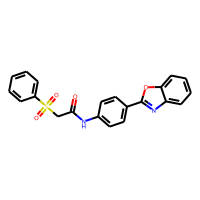

In [26]:
best_pop_at_0.head()

In [27]:
max_at_0 = best_pop_at_0['member'].nunique()
max_overall = best_pop_overall['member'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 15000
max overall: 15000
% improvement: 0.0
 improvement: 0


## target profile changes

#### number of targets

In [28]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(24545, 1)
(1364, 1)
23181


targets
0  CHEMBL3038499
1  CHEMBL1293277
2  CHEMBL1293303
3  CHEMBL1293294
4     CHEMBL5567

In [29]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(26145, 1)
(1484, 1)
24661


targets
0     CHEMBL1784
1  CHEMBL1741209
2     CHEMBL4698
3  CHEMBL1293294
4  CHEMBL1075138

In [30]:
duplicate_overall - duplicate_at_0

1480

In [31]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 1364
max overall: 1484
% improvement: 8.797653958944283
 improvement: 120


#### number of pfams

In [32]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [33]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0  CHEMBL3038499    CHEMBL3038499   c349  PF07714            0.948187   
1  CHEMBL3038499    CHEMBL3038499   c471  PF00481            0.992897   
2  CHEMBL1293277    CHEMBL1293277  c3016  PF16414            1.000000   
3  CHEMBL1293303    CHEMBL1293303  c1477  PF00600            1.000000   
4  CHEMBL1293294    CHEMBL1293294  c1464  PF00071            1.000000   

   pfam_novelty_score  in_actives  in_predicted  
0            0.750297           1             1  
1            0.964286           1             1  
2            0.995817           1             1  
3            1.000000           1             1  
4            0.995925           1             1

In [34]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(1534, 8)
(1672, 8)


In [35]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 536
max overall: 564
% improvement: 5.223880597014925
 improvement: 28


### change in median novelty score

In [36]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.740620459789761
max overall: 0.7502971093830421
% improvement: 1.3065598533462026
 improvement: 0.009676649593281073


# novel7_elitist_pfam_novelty_parallel_15k_1500_300_0randoms

## fitness score evolution

In [7]:
evolution_scores = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_15k_1500_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_15k_1500_300_0randoms.csv",encoding='utf-8')

In [8]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [9]:
print(evolution_scores.shape)
evolution_scores.head()

(450000, 3)


fitness  generation   use
0  0.362859           0  True
1  0.353755           0  True
2  0.353810           0  True
3  0.355210           0  True
4  0.360219           0  True

In [10]:
evolution_scores.tail()

fitness  generation    use
449995  0.431814         299  False
449996  0.413541         299  False
449997  0.405035         299  False
449998  0.426357         299  False
449999  0.422609         299  False

In [11]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.362859           0  True
1  0.353755           0  True
2  0.353810           0  True
3  0.355210           0  True
4  0.360219           0  True

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


Text(0, 0.5, 'fitness')

In [13]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  0.366206   True
1           1  0.370125  False
2           2  0.376681  False
3           3  0.378772  False
4           4  0.383599  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

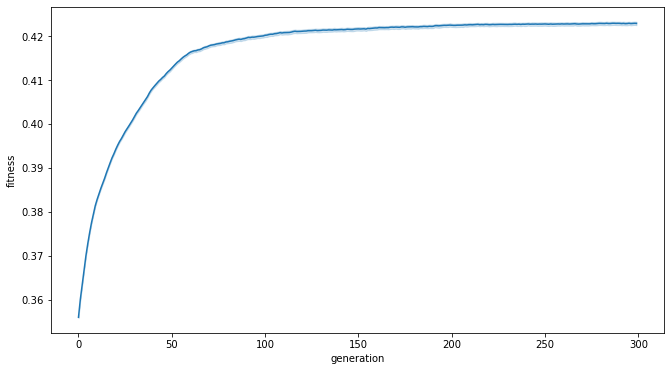

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

(array([0.35, 0.4 , 0.45]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

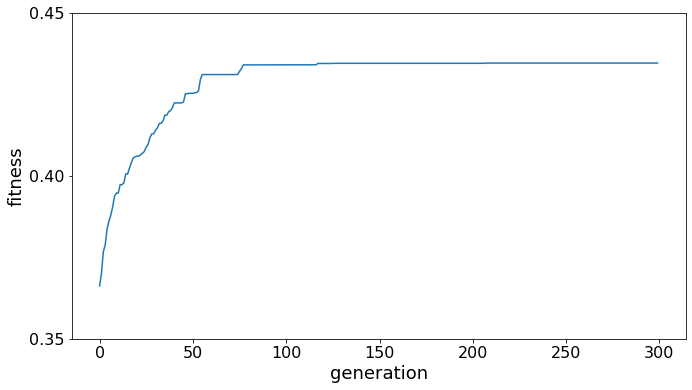

In [18]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.35,0.45, .05))
plt.yticks(fontsize=16)

In [46]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.3662055372393774
max overall: 0.4345432022458633
improvement: 18.6610135722267


## population scaffold change

In [47]:
best_pop_at_0 = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_15k_1500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_15k_1500_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [48]:
best_pop_overall = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_15k_1500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_15k_1500_300_0randoms_207.csv",encoding='utf-8',names=['file_index'])

In [49]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

15000
15000


In [50]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                       query_smiles  \
0    121590.0      1737778  CN([C@@H]1CCS(=O)(=O)C1)S(=O)(=O)c1ccc(C2CCCCC...   
1   1220062.0      2060608     COc1ccc(S(=O)(=O)N2CCc3[nH]c4ccc(F)cc4c3C2)cc1   
2    784597.0      2422969          NS(=O)(=O)c1ccc2nc(NC(=O)CCc3ccccc3)sc2c1   
3   1365383.0      1515443  Cn1c2c(c(=O)n(C)c1=O)[C@H](c1ccc([N+](=O)[O-])...   
4    896403.0      2493131  O=C1NC(=O)C(CCc2ccncc2)(C(c2ccccc2)c2ccccc2)C(...   

                                       targets  
0                              {CHEMBL1293232}  
1                                 {CHEMBL3371}  
2  {CHEMBL3242,CHEMBL3594,CHEMBL261,CHEMBL205}  
3                                 {CHEMBL3397}  
4                                  {CHEMBL280}

In [51]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                       query_smiles  \
0   1151477.0      1023992                      C=CCOc1ccc(CNc2ccc(OC)cc2)cc1   
1    334347.0      2615330  O=C(CCc1csc(NS(=O)(=O)c2ccc(F)cc2)n1)Nc1ccc2c(...   
2   1268488.0      2020247          COc1cc(/C=N/c2n[nH]c(=S)n2Cc2ccccc2)ccc1O   
3   1031170.0       968743   C#CCn1/c(=N/C(=O)c2ccc(Br)s2)sc2cc(NC(C)=O)ccc21   
4    739582.0      1170588      C[C@@H](NC(=O)[C@H]1COCCO1)c1cccc(-n2cccn2)c1   

                                            targets  
0                        {CHEMBL1293231,CHEMBL5567}  
1                                      {CHEMBL3577}  
2  {CHEMBL2146316,CHEMBL6032,CHEMBL5149,CHEMBL5896}  
3                                      {CHEMBL5162}  
4                                      {CHEMBL2985}

In [52]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [53]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [54]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 11015
max overall: 10812
% improvement: -1.842941443486155
 improvement: -203


## cluster representation change

In [55]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                       query_smiles  \
0    121590.0      1737778  CN([C@@H]1CCS(=O)(=O)C1)S(=O)(=O)c1ccc(C2CCCCC...   
1   1220062.0      2060608     COc1ccc(S(=O)(=O)N2CCc3[nH]c4ccc(F)cc4c3C2)cc1   
2    784597.0      2422969          NS(=O)(=O)c1ccc2nc(NC(=O)CCc3ccccc3)sc2c1   
3   1365383.0      1515443  Cn1c2c(c(=O)n(C)c1=O)[C@H](c1ccc([N+](=O)[O-])...   
4    896403.0      2493131  O=C1NC(=O)C(CCc2ccncc2)(C(c2ccccc2)c2ccccc2)C(...   

                                       targets  \
0                              {CHEMBL1293232}   
1                                 {CHEMBL3371}   
2  {CHEMBL3242,CHEMBL3594,CHEMBL261,CHEMBL205}   
3                                 {CHEMBL3397}   
4                                  {CHEMBL280}   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                       murcko_smiles  cluster_id   member  
0   O=S1(=O)CC[C@@H](NS(=O)(=O)c2ccc(C3CCCCC3)cc2)C1     1737778  1737778  
1            O=S(=O)(c1ccccc1)N1CCc2[nH]c3ccccc3c2C1     2060608  2060608  
2                      O=C(CCc1ccccc1)Nc1nc2ccccc2s1     2422969  2422969  
3  O=c1[nH]c2c(c(=O)[nH]1)[C@H](c1ccccc1)Nc1ccccc1O2     1515443  1515443  
4  O=C1NC(=O)C(CCc2ccncc2)(C(c2ccccc2)c2ccccc2)C(...     2493131  2493131
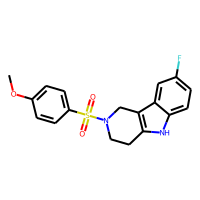
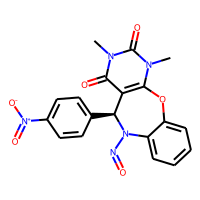
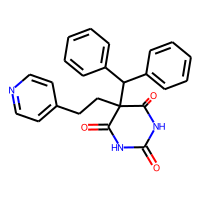

In [56]:
best_pop_at_0.head()

In [57]:
max_at_0 = best_pop_at_0['member'].nunique()
max_overall = best_pop_overall['member'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 15000
max overall: 15000
% improvement: 0.0
 improvement: 0


## target profile changes

#### number of targets

In [58]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(25057, 1)
(1407, 1)
23650


targets
0  CHEMBL1293232
1     CHEMBL3371
2     CHEMBL3242
3     CHEMBL3594
4      CHEMBL261

In [59]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(26764, 1)
(1516, 1)
25248


targets
0  CHEMBL1293231
1     CHEMBL5567
2     CHEMBL3577
3  CHEMBL2146316
4     CHEMBL6032

In [60]:
duplicate_overall - duplicate_at_0

1598

In [61]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 1407
max overall: 1516
% improvement: 7.746979388770433
 improvement: 109


#### number of pfams

In [62]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [63]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0  CHEMBL1293232    CHEMBL1293232  c1757  PF06003            0.013047   
1     CHEMBL3371       CHEMBL3371   c459  PF00001            0.682236   
2     CHEMBL3242       CHEMBL3242  c1363  PF00194            0.932700   
3     CHEMBL3594       CHEMBL3594  c2690  PF00194            0.832864   
4      CHEMBL261        CHEMBL261    c65  PF00194            0.618650   

   pfam_novelty_score  in_actives  in_predicted  
0            0.013047           1             1  
1            0.474948           1             1  
2            0.691573           1             1  
3            0.691573           1             1  
4            0.691573           1             1

In [64]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(1520, 8)
(1711, 8)


In [65]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 442
max overall: 562
% improvement: 27.149321266968325
 improvement: 120


### change in median novelty score

In [66]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.7070653141128309
max overall: 0.745562130177515
% improvement: 5.444591227471944
 improvement: 0.038496816064684136
